In [1]:
import re
import os
import sys
import json
import string
from pathlib import Path 
import csv

import pandas as pd
from collections import Counter
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

from textblob import TextBlob

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download('punkt')

import preprocessor as p

# to view all columns
pd.set_option("display.max.columns", None)

def get_twauth():
    path = Path('.') / '.env/twitter_keys.json'
    twitter_auth = json.load(open(path))
    return twitter_auth

tw_auth = get_twauth()

class tweetsearch():
    '''
    This is a basic class to search and download twitter data.
    You can build up on it to extend the functionalities for more 
    sophisticated analysis
    '''
    def __init__(self, cols=None,auth=None):
        #
        if not cols is None:
            self.cols = cols
        else:
            self.cols = ['id', 'created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author', 'screen_count',
                    'followers_count','friends_count','possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
            
        if auth is None:
            
            #Variables that contains the user credentials to access Twitter API 
            consumer_key = tw_auth['TWITTER_CONSUMER_KEY']
            consumer_secret = tw_auth['TWITTER_CONSUMER_SECRET']
            access_token = tw_auth['TWITTER_ACCESS_TOKEN']
            access_token_secret = tw_auth['TWITTER_ACCESS_TOKEN_SECRET']
            


            #This handles Twitter authetification and the connection to Twitter Streaming API
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
             6.48937,3.37709

        #            
        self.auth = auth
        self.api = tweepy.API(auth, wait_on_rate_limit=True) 
        self.filtered_tweet = ''
            

    def clean_tweets(self, twitter_text):

        #use pre processor
        tweet = p.clean(twitter_text)

         #HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        #Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        #combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)

        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet)
        #after tweepy preprocessing the colon symbol left remain after      
        #removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        #remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        #looping through conditions
        filtered_tweet = []    
        for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        return ' '.join(filtered_tweet)            

    def get_tweets(self, keyword, csvfile=None):
        
        
        df = pd.DataFrame(columns=self.cols)
        

        #page attribute in tweepy.cursor and iteration
        for page in tweepy.Cursor(self.api.search, q=keyword, count=100, include_rts=False, lang='en', tweet_mode='extended').pages():

            # the you receive from the Twitter API is in a JSON format and has quite an amount of information attached
            for status in page:
                
                new_entry = []
                status = status._json
                
                #if this tweet is a retweet update retweet count
                if status['created_at'] in df['created_at'].values:
                    i = df.loc[df['created_at'] == status['created_at']].index[0]
                    #
                    cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                    cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                    if cond1 or cond2:
                        df.at[i, 'favorite_count'] = status['favorite_count']
                        df.at[i, 'retweet_count'] = status['retweet_count']
                    continue

                #calculate sentiment
                filtered_tweet = self.clean_tweets(status['full_text'])
                blob = TextBlob(filtered_tweet)
                Sentiment = blob.sentiment     
                polarity = Sentiment.polarity
                subjectivity = Sentiment.subjectivity

                new_entry += [status['id'], status['created_at'],
                              status['source'], status['full_text'], filtered_tweet, 
                              Sentiment,polarity,subjectivity, status['lang'],
                              status['favorite_count'], status['retweet_count']]

                new_entry.append(status['user']['screen_name'])
                new_entry.append(status['user']['statuses_count'])
                new_entry.append(status['user']['followers_count'])
                new_entry.append(status['user']['friends_count'])
                

                try:
                    is_sensitive = status['possibly_sensitive']
                except KeyError:
                    is_sensitive = None

                new_entry.append(is_sensitive)

                hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags) #append the hashtags

                #
                mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                new_entry.append(mentions) #append the user mentions

                try:
                    xyz = status['place']['bounding_box']['coordinates']
                    coordinates = [coord for loc in xyz for coord in loc]
                except TypeError:
                    coordinates = None
                #
                new_entry.append(coordinates)

                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''
                #
                new_entry.append(location)

                #now append a row to the dataframe
                single_tweet_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_tweet_df, ignore_index=True)

        #
        df['timestamp'] = df.created_at.map(pd.Timestamp)
        df = df.sort_values('timestamp').set_index('timestamp')
        df = df.drop('id',axis=1)
#         print(df.shape[0]) 
        
        if not csvfile is None:
            #save it to file
            df.to_csv(csvfile,mode='a', index=True, encoding="utf-8")
#             print(df.shape[0])
            

        return df 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abubakar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/abubakar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def user_tweets(all_users):
    for user in all_users:
        try:
            ts = tweetsearch()
            df = ts.get_timeline(user, csvfile='twitter_data.csv')
            print(user)
        except tweepy.TweepError as e:
            print(e)
            continue

In [194]:
additional = ['Champions League','UCL','UCL FInal','UEFA Champions League', 'UEFA Men\'s Champions League', 'Machester City FC', 'Chelsea FC']
list_of_places_one = ['Kenya','Nairobi','Kisumu','Mombasa', 'Ghana', 'Egypt']
list_of_places_two = ['Nigeria','Lagos', 'Abuja', "Kaduna", "Kano", 'Ilorin', 'Osun', 'River', 'Ekiti', 'Ibadan', ]
list_of_places_three = ['South Africa','Johannesburg','Cape Town']
list_of_places_four = ['Morocco', 'Angola', 'Ethiopia', 'Rwanda']
all_list_of_places = [list_of_places_one, list_of_places_two, list_of_places_three, list_of_places_four]

In [179]:
list_of_keywords = ['Insecurity','Kidnapping','Drugs','Armed Robbery','Robbery','Rape','Illegal Assult',
                    'Terrorism','Banditry','Bandits','Insurgency','Theft','Bulgary','Murder','Killing Innocent','Ritual Killing','Woobly Security',
                    'Abduct','Laugage Snatch','Bad Governance','Cost of Security','Theifs','Bad Leaders', 'Corruption','Injustice',
                    'Ransom','Cost of Ransom','Stealing', 'Unsafe Environment']

list_of_keywords_fin_tech = ['Mobile Money', 'Flutterwave', "Paystack", 'Mpesa', "Carbon", "PettySave", "Kuda", "MobileMoney", "Airtime", "USSD",
                             'Mpesa Transfer', 'Paystack Credit', 'Carbon MobileMoney Transfer', 'Kuda Transfer', 'Flutterwave wallet', 'Risevest' 
                             'Mobile Money Transfer', 'Mpesa MobileMoney', 'Flutterwave Cashless', 'Etransfer Africa', 'OPay', 'Palmpay', 'OneFi', '#Owo']

list_of_keywords_champions_league = ['football', 'champions', 'manchester city', 'machester', 'soccer', 'Sterling', 'Dias', 'Stones',
                                    'Ederson', 'Aguero', 'Mahrez', 'rudiger', 'De Bruyne', 'Jorginho',
                                    'Edouard Mendy', 'Guardiona', 'Fruadiola', 'Marcos Alonso', 'Thiago Silva', 'N’Golo Kante', 'Christian Pulisic','Timo Werner',
                                     'Edouard Mendy','Mateo Kovacic', 'Olivier Giroud','Mason Mount', 'Ben Chilwell', 'Hakim Ziyech',
                                     'Reece James', 'Cesar Azpilicueta','Kai Havertz','Thomas Tuchel',
                                    'Pulišić', 'Fernandinho', 'Foden', 'Bernardo Silva', 'Zinchenko', 'Walker', 'Gundogan']

def ucl(all_list_of_places):
    ts = tweetsearch()
    file_name = "UCLTweets.csv"
    for list_of_places in all_list_of_places:
            
        for place in list_of_places:
            for item in additional:
                keywords = ['Champions League',place,item]
                final_keywords = " AND ".join(keywords)
                try:
                    df = ts.get_tweets(keyword=final_keywords, csvfile=file_name)
                    print(final_keywords)
                except tweepy.TweepError:
                    continue

        for keyword in list_of_keywords_champions_league:
            for place in list_of_places:
                keywords = [keyword,place]
                final_keywords = " AND ".join(keywords)
                try:
                    ts = tweetsearch() 
                    df = ts.get_tweets(final_keywords, csvfile=file_name)
                    print(final_keywords)
                except tweepy.TweepError:
                    continue

                for item in additional:
                    keywords = [keyword,place,item]
                    final_keywords = " AND ".join(keywords)
                    try:
                        ts = tweetsearch() 
                        df = ts.get_tweets(final_keywords, csvfile=file_name)
                        print(final_keywords)
                    except tweepy.TweepError:
                        continue

In [207]:
champions_league_keywords = []
for list_of_places in all_list_of_places:
    for place in list_of_places:
        for item in additional:
            keywords = ['Champions League', place, item]
            final_keywords = " AND ".join(keywords)
            champions_league_keywords.append(final_keywords)
    for keyword in list_of_keywords_champions_league:
        for place in list_of_places:
            keywords = [keyword,place]
            final_keywords = " AND ".join(keywords)
            champions_league_keywords.extend(final_keywords)
        for item in additional:
            keywords = [keyword,place,item]
            final_keywords = " AND ".join(keywords)
            champions_league_keywords.extend(final_keywords)

In [ ]:
from tweepy import Stream
from tweepy.streaming import StreamListener


list_of_keywords_fin_tech = ['Mobile Money', 'Flutterwave', "Paystack", 'Mpesa', "Carbon", "PettySave", "Kuda", "MobileMoney", "Airtime", "USSD",
                             'Mpesa Transfer', 'Paystack Credit', 'Carbon MobileMoney Transfer', 'Kuda Transfer', 'Flutterwave wallet', 'Risevest' 
                             'Mobile Money Transfer', 'Mpesa MobileMoney', 'Flutterwave Cashless', 'Etransfer Africa', 'OPay', 'Palmpay', 'OneFi', 'Owo']

covid_keywords = ['COVID19 Rwanda', 'COVID19 Vaccination South Africa', 'Sars-Cov2 Mutation sierra leone', 'Corona Virus Egypt', 'CoronaVirus Ghana', 
                  'Covid19 Vaccines South Africa','COVID19 Nigeria', 'COVID19 Vaccination Ghana','COVID19 Vaccination Nigeria', 'CoronaVirus Rwanda',
                 'CoronaVirus Ghana', 'Corona Virus Benin',]

class MyListener(StreamListener):
    
         #This handles Twitter authetification and the connection to Twitter Streaming API
#         auth = OAuthHandler(consumer_key, consumer_secret)
#         auth.set_access_token(access_token, access_token_secret)

        
#     def on_status(self, status):
# #         if status.user.retweeted:
# #             return
#         if status.favorite_count is None or status.favorite_count < 10:
#             return
#         try:
#             with open('fintech_file.json', 'a') as f:
#                 f.write(status)
#                 return True

    def on_data(self, data):
#         if data.favorite_count is None or data.favorite_count < 10:
#             return
#         if data.user.retweeted:
#             return
        try:
            with open('covid19Original.json', 'a') as f:
                f.write(data)
                return True
    
            
        except BaseException as e:
            print(f"Error on_data: {e}")     
        return True
    
    def on_error(self, status):
         if status == 420:
            print(status)
        
ts = tweetsearch()   
twitter_stream = Stream(ts.auth, MyListener())
twitter_stream.filter(track=covid_keywords, languages = ["en"])

In [211]:
from tweepy import Stream
from tweepy.streaming import StreamListener
covid_keywords = ['COVID19 Rwanda', 'COVID19 Vaccination South Africa', 'Sars-Cov2 Mutation sierra leone', 'Corona Virus Egypt', 'CoronaVirus Ghana', 
                  'Covid19 Vaccines South Africa','COVID19 Nigeria', 'COVID19 Vaccination Ghana','COVID19 Vaccination Nigeria', 'CoronaVirus Rwanda',
                 'CoronaVirus Ghana', 'Corona Virus Benin',]

ts = tweetsearch() 
class MyListener(StreamListener):
    
    def on_data(self, data):
        try:
            with open('champions_league.json', 'a') as f:
                f.write(data)
                return True
        except BaseException as e:
            print(f"Error on_data: {e}")
            
        return True
    
    def on_error(self, status):
        print(status)
        return True
    
twitter_stream = Stream(ts.auth, MyListener())
twitter_stream.filter(track=champions_league_keywords, is_async=True, languages='en')

406
406
406
406
406
406


KeyboardInterrupt: 

In [49]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='twitter-analysis-cl')

locs = list(locs.index)

In [51]:
geolocated = list(map(lambda x: [x, geolocator.geocode(x)[1] if geolocator.geocode(x) else None], locs))

geolocated = pd.DataFrame(geolocated)
geolocated.columns = ['location', 'latlong']

geolocated['lat'] = geolocated.latlong.apply(lambda x: x[0])
geolocated['lon'] = geolocated.latlong.apply(lambda x: x[1])
geolocated.drop('latlong', axis=1, inplace=True)

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=20-10-20&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [ ]:
geolocated.head(10)

In [ ]:
mapdata = pd.merge(d, geolocated, how='inner', left_on='place_coord_boundaries', right_on='location')

locations = mapdata.groupby(by=['location', 'lat', 'lon']).count()['created_at'].sort_values(ascending=False)

In [ ]:
locations.head(10)

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (20, 10)

## Class Automation

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

class Automation:
    """
    The PEP8 Standard AMAZING!!!
    """
    def __init__(self):
        print('Automation in Action...!!!')

    def Clean_Tweets(self, df):
        # drop na in clean tweets column
        a = df[df['retweet_count'] == 'retweet_count' ].index
        df.drop(a , inplace=True)
        # dropduplicates and drop duplicates in clean tweets
        df = df.drop_duplicates().drop_duplicates(subset='clean_text')
        # convert int column appropriately
        df = df[df['polarity'] != 'polarity']
        # convert the created_at column to a datetime object
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d')
        df = df[df['created_at'] >= '2020-12-31' ]
        # convert int column appropriately
        df['polarity'] = pd.to_numeric(df['polarity'], errors='coerce')
        df['subjectivity'] = pd.to_numeric(df['subjectivity'], errors='coerce')
        df['retweet_count'] = pd.to_numeric(df['retweet_count'], errors='coerce')
        df['favorite_count'] = pd.to_numeric(df['favorite_count'], errors='coerce')
        return df

    def Time_Trend(self, df, city,x):
        ax = df.groupby('created_at')[['retweet_count', 'favorite_count']].sum().plot(figsize=(20,8))
        plt.title(f'Trend of likes and retweets for {city}', size=20)
        plt.axvline(x=x,color='gray',linestyle='--')
        plt.ylabel('Frequency', fontsize=14)
        plt.xlabel('Time', fontsize=14)
        plt.xticks(rotation=45)
        plt.show()
        
        
    def Draw_Wordcloud(self, tweets_series, description):
        # word cloud visualization
        allWords = ' '.join([twts for twts in tweets_series])
        stopwords = list(STOPWORDS) + ["https", 'http', 't', 'amp', 'rt']
        wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110, stopwords=stopwords, collocations=False).generate(allWords)
        plt.figure(figsize=(15, 12))
        plt.imshow(wordCloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f'Most used words describing {description}', size=20)
        plt.show()
        

In [108]:
auto = Automation()

Automation in Action...!!!


In [30]:
df = auto.Clean_Tweets(d)

In [31]:
df.shape

(1257, 20)

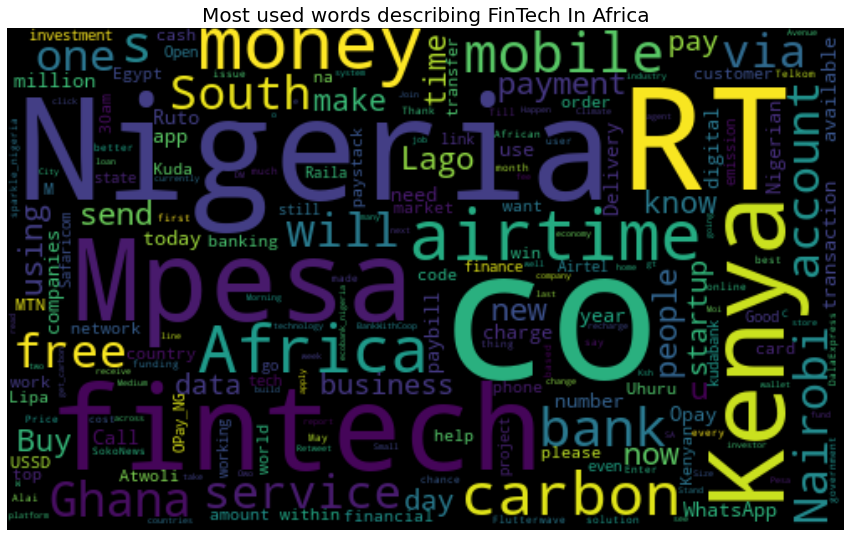

In [32]:
auto.Draw_Wordcloud(df['original_text'], 'FinTech In Africa')


In [33]:
import re
hashtags = df['original_text'].apply(lambda x: pd.value_counts(re.findall('(#\w+)', x.lower() ))).sum(axis=0).to_frame()\
        .reset_index().sort_values(by=0, ascending=False)

hashtags.columns=['hashtags', 'occurences']

hashtags.head(10)

,hashtags,occurences
242,#fintech,83.0
435,#nigeria,51.0
328,#kenya,25.0
167,#dalaexpress,22.0
532,#sokonews,22.0
26,#africa,22.0
65,#bankwithcoop,21.0
267,#ghana,20.0
589,#tsenda,16.0
249,#fitnfabgear,15.0


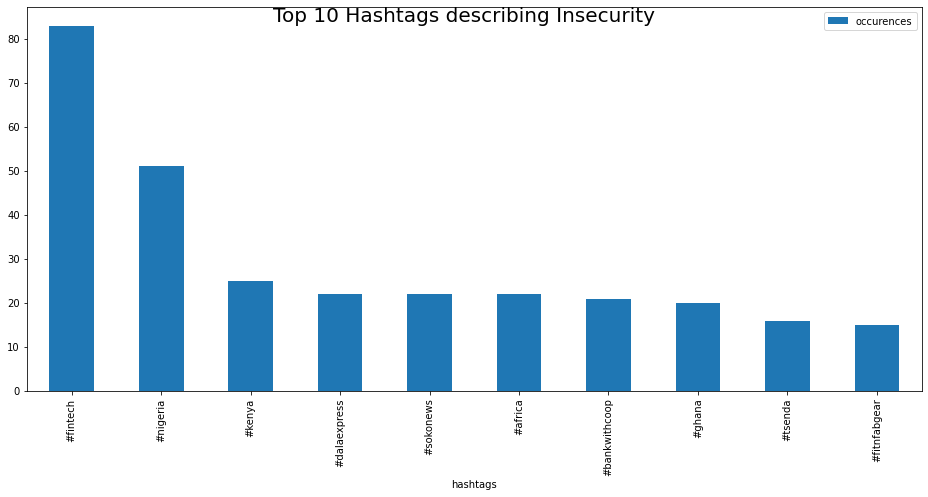

In [34]:
hashtags[:10].plot.bar(x='hashtags', y='occurences', figsize=(13, 7))
plt.tight_layout()
plt.grid(False)
plt.suptitle("Top 10 Hashtags describing Insecurity", size=20);

<AxesSubplot:>

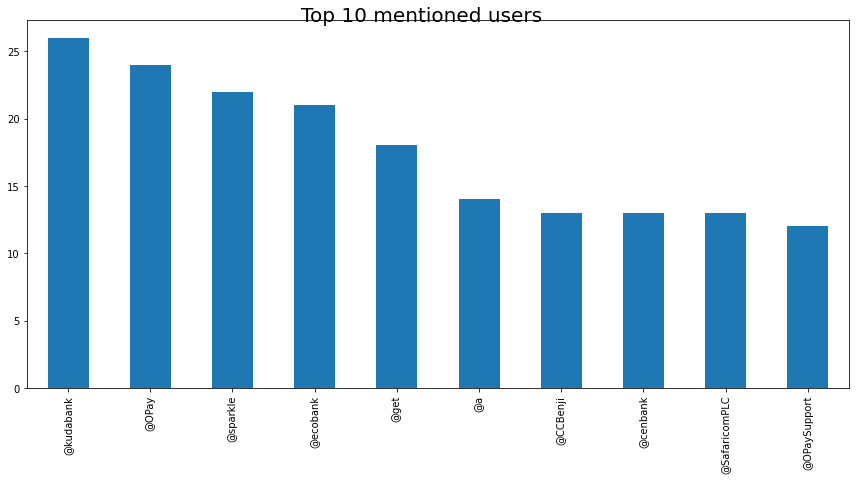

In [35]:
# user mention
plt.grid(False)
plt.tight_layout()
plt.suptitle("Top 10 mentioned users", size=20)
df['original_text'].str.findall('(@[A-Za-z0-9]+)').apply(lambda x: pd.value_counts(x)).sum(axis=0).sort_values(ascending=False)[:10].plot.bar(figsize=(13,6))

In [36]:
df.groupby(['hashtags', 'original_author']).\
            agg({'retweet_count': 'mean', 'favorite_count': 'mean'}).sort_values(by='retweet_count', ascending=False)[:10]

,,retweet_count,favorite_count
hashtags,original_author,,
"ActOnClimate, climatesolutions, climatecrisis, GreenNewDeal, nature",MikeHudema,124.0,243.0
PalmPaySuperEid,biggie_of_lagos,122.0,0.0
cryptocurrency,Lastepisode9,116.0,125.0
"Nigeria, Tech",eo_anaja,109.0,0.0
"Wizkid, SOLANA, June12Protest",driipdaklothier,103.0,108.0
"MasculinitySaturday, UCLFinal",Lastepisode9,90.0,88.0
Nigeria,Chxta,81.0,145.0
"LuoMaturity, maischberger",_tribesman,66.0,67.0
"DalaExpress, LakersVsSuns, javascript",_tribesman,62.0,74.0


In [37]:
tt = df.groupby(['original_author'])['hashtags'].value_counts().sort_values(ascending=False)

tt = pd.DataFrame(tt)
tt.columns = ['counts_hashtags']
tt.reset_index(inplace=True)
tt.columns

Index(['original_author', 'hashtags', 'counts_hashtags'], dtype='object')

In [38]:
tt=tt[tt['hashtags'] != 'NotCommon']

tt.groupby(['hashtags', 'original_author']).sum().sort_values(by='counts_hashtags', ascending=False)

,,counts_hashtags
hashtags,original_author,
sokonews,bryanmanyonge28,10
"Owo, NG",Bootacle,8
Tsenda,bennetowuonda,5
"BankwithCoop, SokoWeekend",Raptor_Kenya,5
"fitnfabgear, fitnesswear, gymwearshop, fitnfabworld, sport",fitnfabworld,5
...,...,...
"Kalembe_Ndile, AHealingOfWounds, GodSpeaks, Nairobi_Hospital, GodIsWorkingOnMe",MemeHub60408032,1
"Kalembe_Ndile, AHealingOfWounds, GodSpeaks, Nairobi_Hospital",MemeHub60408032,1
"Jamb2021, ExtendJambReg2021, Buharimustgo, BenueUnderAttack, Africa",ChrisEnemoh,1


In [39]:
df['place_coord_boundaries'].value_counts()

Nairobi, Kenya                137
Lagos, Nigeria                 72
Nigeria                        40
Nairobi                        23
Kenya                          23
                             ... 
Katlehong, South Africa         1
Bloemfontein, South Africa      1
Kwahu Tafo, Ghana               1
Cross River, Nigeria            1
Basel, Schweiz                  1
Name: place_coord_boundaries, Length: 412, dtype: int64

In [40]:
words = df['original_text'].dropna().apply(lambda x: pd.value_counts(re.findall('([\s]\w+[\s])',' '.join(x)))).sum(axis=0).to_frame().reset_index().sort_values(by=0,
    ascending=False)
words.columns = ['word', 'occurences']

words.head(10)

,word,occurences
0,t,8936.0
1,e,8679.0
5,a,8345.0
3,s,6398.0
6,i,6266.0
4,r,5691.0
12,n,5650.0
2,o,5046.0
8,c,4000.0
22,l,3662.0


In [42]:
from nltk import bigrams

bigram_series = pd.Series(sublist for sublist in df['clean_text'].dropna().apply(lambda x: [i for i in bigrams(x)]).tolist())

In [44]:
df.to_csv('finTechTweets.csv', index=False)

## Vaccination in Africa EDA

In [52]:
tw = pd.read_csv('VaccinationTweets.csv')
tw.shape

/workspace/.conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(469855, 17)

In [64]:
clean_tw = auto.Clean_Tweets(tw)
clean_tw.shape

/workspace/.conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/workspace/.conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(351071, 17)

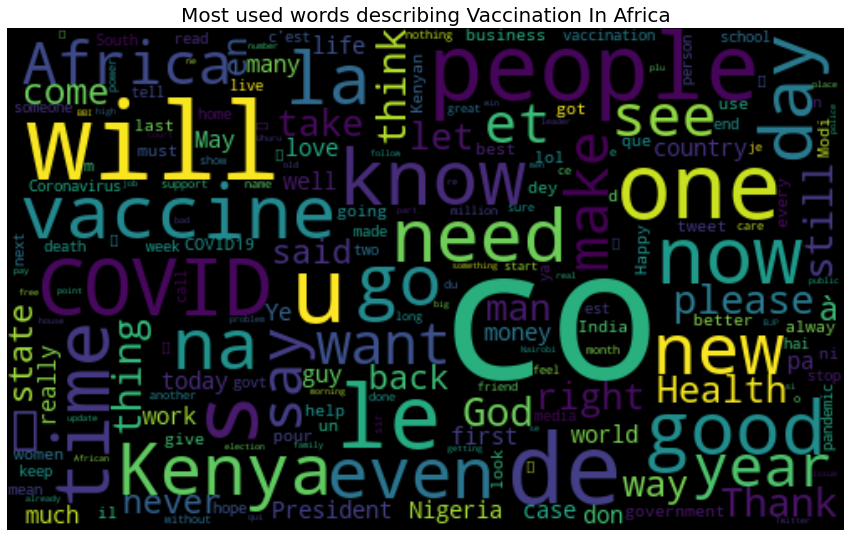

In [65]:
auto.Draw_Wordcloud(clean_tw['original_text'], 'Vaccination In Africa')


In [66]:
clean_tw['original_text'].sample(20).values

array(['@TheStarKenya "Payment delayed by government processes..." Covid-19 be damned!?!',
       '@eniturn Maybe he sells Sharwama',
       "Yall my family &amp; probably ALL but one of my friends has broken ALL the rules of COVID from day #1🤦🏾\u200d♀️ Same muthafuckas who don't want the vaccine smh",
       '@MonaAmbegaonkar Hmm. There are still 3 years to go for Modi to get re elected !!',
       'Uhuru leads party leaders in calling for an end to political antagonism: President Uhuru Kenyatta now urges Kenyans to put aside their political differences for the sake of the country’s development.. https://t.co/gC8CNalFjJ',
       "@KelvinOssai Maybe when I get into a relationship, I'd come back and quote this tweet",
       "They'll price you out of that hamburger habit. https://t.co/mVBttAY2bB",
       '@cocoqt81 My ex did this. showed up with a motorcycle one day after arguing the mortgage over having a date night.',
       'Isn’t this the guy who got crazy drunk and disappeared the 

/workspace/.conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


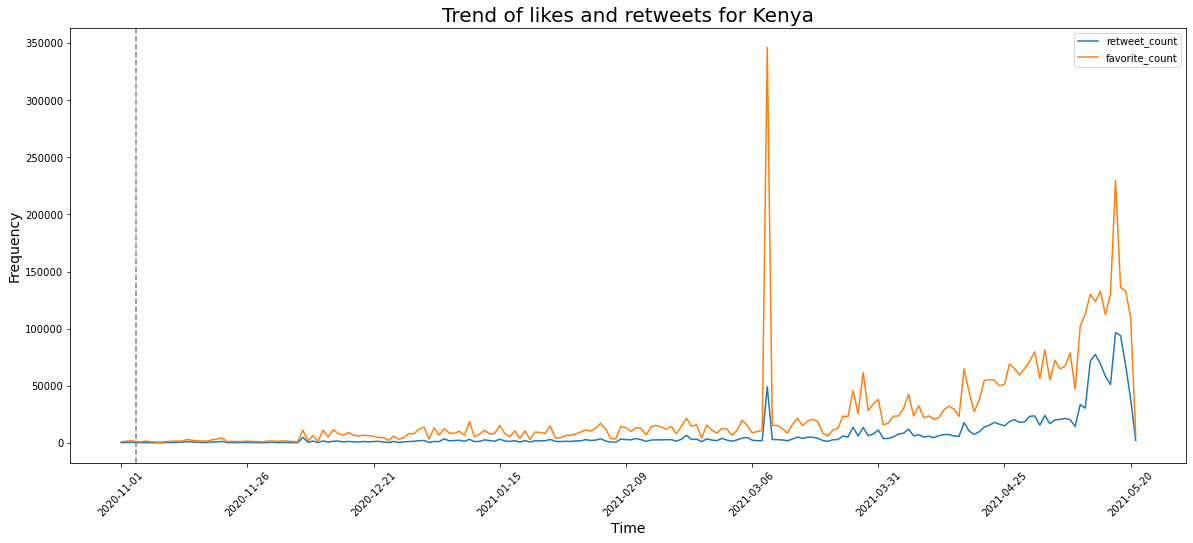

In [67]:
auto.Time_Trend(clean_tw, 'Kenya', 3)

In [68]:
clean_tw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351071 entries, 0 to 469854
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   timestamp               351071 non-null  object 
 1   created_at              351071 non-null  object 
 2   source                  351071 non-null  object 
 3   original_text           351071 non-null  object 
 4   clean_text              351070 non-null  object 
 5   sentiment               351071 non-null  object 
 6   polarity                351071 non-null  float64
 7   subjectivity            351071 non-null  float64
 8   lang                    351071 non-null  object 
 9   favorite_count          351071 non-null  int64  
 10  retweet_count           351071 non-null  int64  
 11  original_author         351071 non-null  object 
 12  possibly_sensitive      119693 non-null  object 
 13  hashtags                40124 non-null   object 
 14  user_mentions       

In [90]:
recent_df = clean_tw[clean_tw['created_at'] >= "2021-03-01"]
recent_df.shape

(265229, 17)

/workspace/.conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


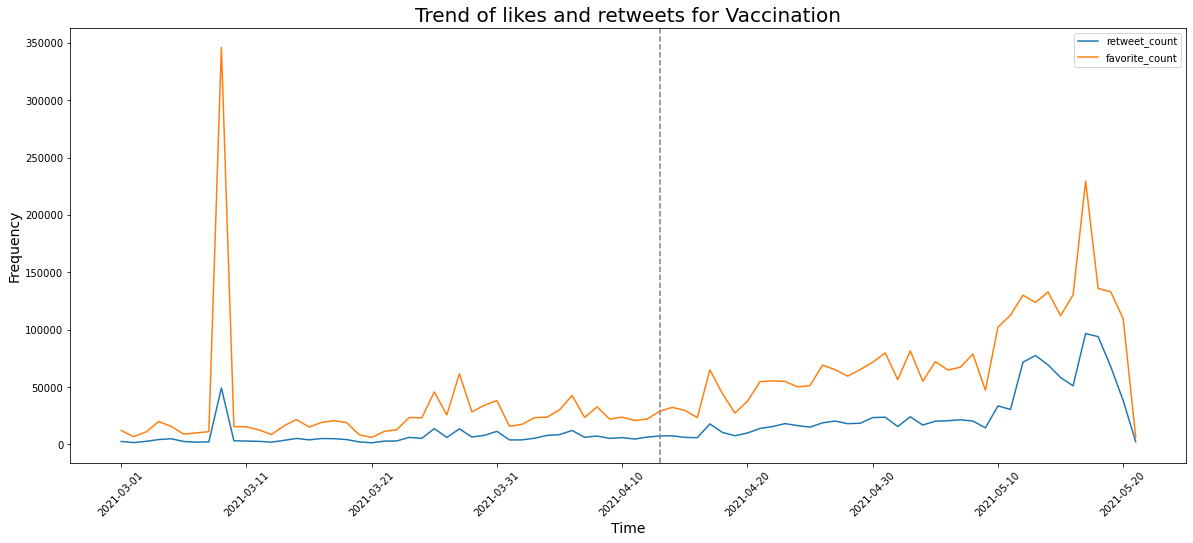

In [71]:
auto.Time_Trend(recent_df, 'Vaccination', 43)

In [74]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default='iframe'

In [82]:
ax = recent_df.groupby('created_at')[['retweet_count', 'favorite_count']].sum().reset_index()
fig = px.line(ax, x="created_at", y=['retweet_count', 'favorite_count'])
fig.show()

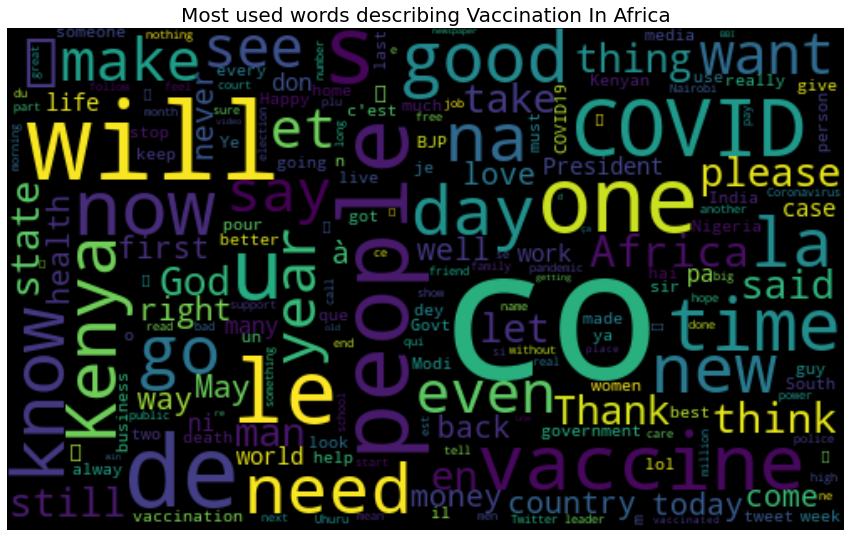

In [81]:
auto.Draw_Wordcloud(recent_df['original_text'], 'Vaccination In Africa')

In [ ]:
from nltk.corpus import reuters
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

# Create a placeholder for model
model = defaultdict(lambda: defaultdict(lambda: 0))

# Count frequency of co-occurance  
for sentence in reuters.sents():
    for w1, w2, w3 in trigrams(sentence, pad_right=True, pad_left=True):
        model[(w1, w2)][w3] += 1
 
# Let's transform the counts to probabilities
for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count

In [91]:
recent_df['clean_text'].dropna(inplace=True)

<ipython-input-91-6ed9a5ceac7e>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [92]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=STOPWORDS, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(recent_df['clean_text'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

MemoryError: Unable to allocate 6.01 TiB for an array with shape (265228, 3116029) and data type int64

In [95]:
fintech = pd.read_csv('finTechTweets.csv', low_memory=False)
insecurity = pd.read_csv('insecurtyTweets.csv', low_memory=False)
vaccine = pd.read_csv('VaccinationTweets.csv', low_memory=False)

In [96]:
fintech.shape, insecurity.shape, vaccine.shape

((1257, 20), (252371, 17), (469855, 17))

In [97]:
fintech.head(2)

,timestamp,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,screen_count,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,2021-05-26 12:50:59+00:00,2021-05-26,"<a href=""http://twitter.com/download/android"" ...",Great to see startups on this list from countr...,Great see startups list countries outside `` b...,"Sentiment(polarity=0.25, subjectivity=0.325)",0.25,0.325,en,0,0,Queen_Ne4titi,5028,303,908,False,NaN,NaN,NaN,The entire black world
1,2021-05-26 17:28:04+00:00,2021-05-26,"<a href=""https://www.flyingeze.com/"" rel=""nofo...",African fintech OPay is reportedly raising $40...,African fintech OPay reportedly raising 400M 1...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.00,0.000,en,0,0,flyingeze,135060,1827,1554,False,"Africa, Finance, Funding, Payments, Startups, ...",NaN,NaN,NaN


In [141]:
df = pd.concat([fintech, insecurity.head(50000), vaccine.head(50000)])

df.shape

(101257, 20)

In [142]:
df = auto.Clean_Tweets(df)

df.shape

(38502, 20)

In [143]:
df.head()

,timestamp,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,screen_count,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,2021-05-26,2021-05-26,"<a href=""http://twitter.com/download/android"" ...",Great to see startups on this list from countr...,Great see startups list countries outside `` b...,"Sentiment(polarity=0.25, subjectivity=0.325)",0.250,0.325000,en,0,0,Queen_Ne4titi,5028,303,908,False,NaN,NaN,NaN,The entire black world
1,2021-05-26,2021-05-26,"<a href=""https://www.flyingeze.com/"" rel=""nofo...",African fintech OPay is reportedly raising $40...,African fintech OPay reportedly raising 400M 1...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000,0.000000,en,0,0,flyingeze,135060,1827,1554,False,"Africa, Finance, Funding, Payments, Startups, ...",NaN,NaN,NaN
2,2021-05-26,2021-05-26,"<a href=""http://twitter.com/download/iphone"" r...",RT @DollyOgutu: 🇰🇪Kenya’s second-place reflect...,Kenyas second-place reflected immense growth r...,"Sentiment(polarity=0.0, subjectivity=0.625)",0.000,0.625000,en,0,6,asepkij,32398,208,327,NaN,NaN,DollyOgutu,NaN,NaN
3,2021-05-26,2021-05-26,"<a href=""https://dlvrit.com/"" rel=""nofollow"">d...",Kenyan regulators set their sights on free-and...,Kenyan regulators set sights free-and-easy fin...,"Sentiment(polarity=-0.15, subjectivity=0.2)",-0.150,0.200000,en,0,0,SuriyaSubraman,327734,5064,3482,False,"finpeform, fintech",NaN,NaN,"London, UK"
4,2021-05-26,2021-05-26,"<a href=""https://buffer.com"" rel=""nofollow"">Bu...",Did you know elephants are afraid of bees? @Dr...,Did know elephants afraid bees simple innovati...,"Sentiment(polarity=-0.175, subjectivity=0.7892...",-0.175,0.789286,en,4,1,patmitchell,4588,7925,1098,False,NaN,"DrLucyKing, ste_kenya",NaN,"New York, NY"


In [144]:
df.describe()

,polarity,subjectivity,favorite_count,retweet_count
count,38502.000000,38502.000000,38502.000000,38502.000000
mean,0.072721,0.280776,5.426835,12.257104
std,0.268126,0.319712,129.747675,302.821053
min,-1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.150000,0.000000,0.000000
75%,0.160000,0.516337,1.000000,0.000000
max,1.000000,1.000000,17121.000000,33673.000000


## Text Analytics

In [145]:
d = df[['clean_text', 'polarity', 'subjectivity', 'favorite_count', 'retweet_count']]

In [146]:
stop_words = stopwords.words('english')

In [147]:
d = d.dropna()
d.isna().sum()

clean_text        0
polarity          0
subjectivity      0
favorite_count    0
retweet_count     0
dtype: int64

In [148]:
# using list comprehension + enumerate() + split()
# for Bigram formation
clean_text = d['clean_text'].values[:100]
res = [(x, i.split()[j + 1]) for i in clean_text 
       for j, x in enumerate(i.split()) if j < len(i.split()) - 1]
  

In [165]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stop_words, ngram_range=(2,3), max_features=4000)
# matrix of ngrams
ngrams = c_vec.fit_transform(d['clean_text'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [166]:
df_ngram.head()

,frequency,bigram/trigram
0,1143,south africa
1,940,covid 19
2,471,insecurity nigeria
3,333,19 vaccine
4,327,covid 19 vaccine


In [159]:
from textblob import TextBlob

In [167]:
df_ngram['polarity'] = df_ngram['bigram/trigram'].apply(lambda x: TextBlob(x).polarity)
df_ngram['subjective'] = df_ngram['bigram/trigram'].apply(lambda x: TextBlob(x).subjectivity)

In [168]:
df_ngram.head(20)

,frequency,bigram/trigram,polarity,subjective
0,1143,south africa,0.0,0.0
1,940,covid 19,0.0,0.0
2,471,insecurity nigeria,0.0,0.0
3,333,19 vaccine,0.0,0.0
4,327,covid 19 vaccine,0.0,0.0
5,247,happy birthday,0.8,1.0
6,223,vaccine rollout,0.0,0.0
7,218,god bless,0.0,0.0
8,208,good morning,0.7,0.6
9,181,covid vaccine,0.0,0.0


In [169]:
df_ngram.describe()

,frequency,polarity,subjective
count,4000.00000,4000.000000,4000.000000
mean,14.11375,0.029683,0.084534
std,28.86874,0.166410,0.213045
min,6.00000,-1.000000,0.000000
25%,7.00000,0.000000,0.000000
50%,9.00000,0.000000,0.000000
75%,14.00000,0.000000,0.000000
max,1143.00000,1.000000,1.000000


## Topic Modelling NMF Model

In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline

In [170]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,3))
nmf = NMF(n_components=3)
pipe = make_pipeline(tfidf_vectorizer, nmf)
pipe.fit(d['clean_text'])


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [171]:
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=3)

Topic #0: covid 19, 19 vaccine, covid 19 vaccine
Topic #1: good morning, morning sir, good morning sir
Topic #2: abuja kaduna, block abuja, kaduna highway



To improve this, Instead of 3 topics which might not be optimal, a grid search can help select the best topic for this model NMF

<b>LDA models</b>

Latent Dirichlet Allocation is a generative probabilistic model for collections of discrete dataset such as text corpora. It is also a topic model that is used for discovering abstract topics from a collection of documents.

In [173]:
from sklearn.decomposition import LatentDirichletAllocation
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,3))
lda = LatentDirichletAllocation(n_components=3)
pipe = make_pipeline(tfidf_vectorizer, lda)
pipe.fit(d['clean_text'])



Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(2, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('latentdirichletallocation',
                 LatentDirichletAllocation(n_components=3))])

In [174]:
print_top_words(lda, tfidf_vectorizer.get_feature_names(), n_top_words=3)

Topic #0: south africa, insecurity nigeria, covid 19
Topic #1: south africa, good morning, covid 19
Topic #2: covid 19, south africa, god bless



In [175]:
df.to_csv("all_data_combined.csv", index=False)

In [183]:
ucl_tw = pd.read_csv("UCLTweets.csv")
ucl_tw.head()

,timestamp,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,screen_count,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,2021-05-30 10:48:20+00:00,Sun May 30 10:48:20 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @Kianangih: Congratulations to Ngolo Wafula...,Congratulations Ngolo Wafula Kante becoming nd...,"Sentiment(polarity=0.625, subjectivity=0.625)",0.625,0.625,en,0,1184,DruidUtd,29154,468,350,NaN,NaN,Kianangih,NaN,"Nairobi, Kenya"
1,2021-05-30 10:48:47+00:00,Sun May 30 10:48:47 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","RT @gabrieloguda: 16,500 fans allowed into the...",fans allowed stadium watch Champions League fi...,"Sentiment(polarity=0.0, subjectivity=1.0)",0.0,1.0,en,0,54,Gordon75672623,11504,151,393,NaN,NaN,gabrieloguda,NaN,NaN
2,2021-05-30 10:54:47+00:00,Sun May 30 10:54:47 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @Kianangih: Congratulations to Ngolo Wafula...,Congratulations Ngolo Wafula Kante becoming nd...,"Sentiment(polarity=0.625, subjectivity=0.625)",0.625,0.625,en,0,1184,deechepy,41756,6689,5915,NaN,NaN,Kianangih,NaN,D.C 🌍
3,2021-05-30 10:55:31+00:00,Sun May 30 10:55:31 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @Kianangih: Congratulations to Ngolo Wafula...,Congratulations Ngolo Wafula Kante becoming nd...,"Sentiment(polarity=0.625, subjectivity=0.625)",0.625,0.625,en,0,1184,NjapitMwaana,18647,6202,6690,NaN,NaN,Kianangih,NaN,"Eldoret, Kenya"
4,2021-05-30 10:58:31+00:00,Sun May 30 10:58:31 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @Kianangih: Congratulations to Ngolo Wafula...,Congratulations Ngolo Wafula Kante becoming nd...,"Sentiment(polarity=0.625, subjectivity=0.625)",0.625,0.625,en,0,1184,lewis_4th,29239,1208,857,NaN,NaN,Kianangih,NaN,mumu humu jijini | Nairobi


In [184]:
ucl_tw = auto.Clean_Tweets(ucl_tw)

ucl_tw.shape

(7796, 20)

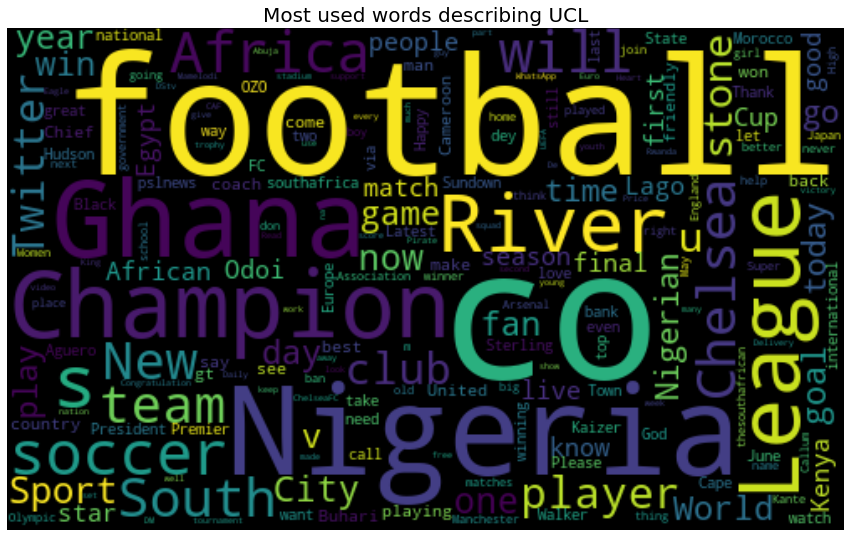

In [188]:
auto.Draw_Wordcloud(ucl_tw['original_text'], 'UCL')

/workspace/.conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning:

FixedFormatter should only be used together with FixedLocator



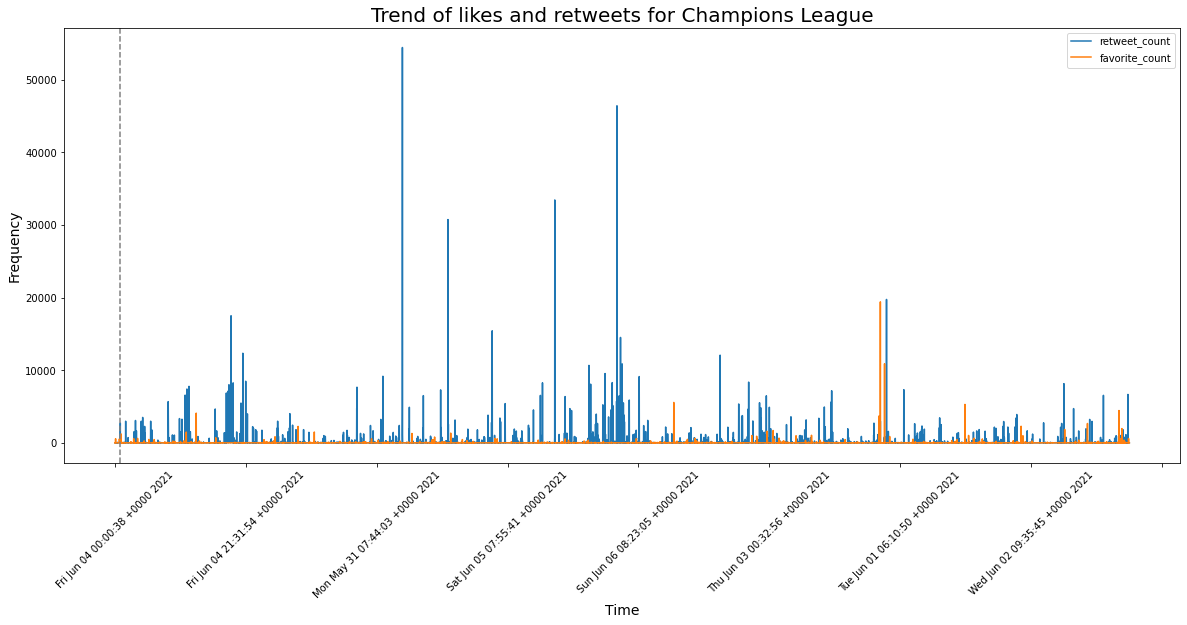

In [189]:
auto.Time_Trend(ucl_tw, 'Champions League', 43)

In [191]:
ucl_tw.dropna(inplace=True)

In [192]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,3))
nmf = NMF(n_components=3)
pipe = make_pipeline(tfidf_vectorizer, nmf)
pipe.fit(ucl_tw['clean_text'])

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(2, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('nmf', NMF(n_components=3))])

In [193]:
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=4)

Topic #0: qng get maine, conceived people asking, train spotting qng, train spotting
Topic #1: world bicycle day, home champions, bicycle day, bicycle day spendings3rd
Topic #2: quality dream, morocco quality dream, futsal morocco, dream big



In [3]:
def read_json(json_file: str)->list:
    """
    json file reader to open and read json files into a list
    Args:
    -----
    json_file: str - path of a json file
    
    Returns
    -------
    length of the json file and a list of json
    """
    
    tweets_data = []
    for tweets in open(json_file,'r'):
        tweets_data.append(json.loads(tweets))
    
    
    return len(tweets_data), tweets_data

In [4]:
_, data = read_json('insecurity.json')